In [1]:
import glob
import os
import re
import copy
from datetime import datetime
from functools import lru_cache
from functools import wraps

import nltk
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.metrics.distance import edit_distance
from nltk.stem.snowball import PorterStemmer
from scipy.sparse import find, tril
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from tabulate import tabulate
import spacy
import itertools
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from collections import Counter

In [2]:
# import ssl
#
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
#
#
# nltk.download('words')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

# Init help functions

In [3]:
corpus_words = np.array(words.words())
print(len(corpus_words))
vectorizer_char = CountVectorizer(analyzer='char', ngram_range=(1, 2))
nn = NearestNeighbors()
nn.fit(vectorizer_char.fit_transform(corpus_words))


@lru_cache(maxsize=300_000)
def spell_corrector(word):
    word = word.lower()
    if len(set(word)) <= 2: return word

    inx = nn.kneighbors(vectorizer_char.transform([word]), n_neighbors=200, return_distance=False)

    temp = [(edit_distance(word, w), w) for w in corpus_words[inx][0] if w[0] == word[0]]

    res = sorted(temp, key=lambda val: val[0])
    if res:
        return res[0][1]
    else:
        return word

def predict(solution, text):
    store = solution.store
    X = pd.DataFrame(text, columns=['source'])
    df =  pd.concat([pd.concat([pd.DataFrame(store['name']), pd.DataFrame(store['model'].apply(lambda x: x.predict(X.iloc[index].values.reshape(-1, 1))[0]))], axis=1).set_index('name').T for index in X.index], keys=X['source'].tolist())
    df = df.reset_index()
    return df.drop(['level_1'], axis=1).set_index('level_0').rename_axis(columns='transformation', index='source')

def as_table(head):
    def wrapper(method):
        @wraps(method)
        def _impl(self, *method_args, **method_kwargs):
                method_output = method(self, *method_args, **method_kwargs)
                display(HTML(tabulate(method_output, headers=['pipeline', *head], tablefmt='html', showindex="always")))
                return None
        return _impl
    return wrapper

236736


# Solution class

In [4]:
class Solution:

    class TweetFeatureExtractor(BaseEstimator, TransformerMixin):

        def fit(self, X, y=None):
            return self

        def transform(self, X, y=None):

            X = pd.Series(X)
            out = pd.DataFrame(
                {
                    'n_chars': X.apply(lambda x: len(x.replace(' ', ''))),
                    'n_words': X.apply(lambda x: max(x.count(' '),1)),
                    'n_numeric': X.apply(lambda x: len([i for i in x if i.isdigit()])),
                    'avg_word_len': X.apply(lambda x: sum([len(i) for i in x.split(' ')])/len(x.split(' '))),
                    'xD': X.apply(lambda x: x.count('xD')),
                    ':D': X.apply(lambda x: x.count(':D')),
                    ')': X.apply(lambda x: x.count(')')),
                    '(': X.apply(lambda x: x.count(')')),
                    '!': X.apply(lambda x: x.count('!')),
                    '!!': X.apply(lambda x: x.count('!!')),
                    '!!!': X.apply(lambda x: x.count('!!!')),
                    '.': X.apply(lambda x: x.count('.')),
                    '...': X.apply(lambda x: x.count('...')),
                    ':/': X.apply(lambda x: x.count(':/')),
                    ":'" : X.apply(lambda x: x.count(":'")),
                    ':-)': X.apply(lambda x: x.count(":-)")),
                    ':-(': X.apply(lambda x: x.count(":-(")),
                    ':(': X.apply(lambda x: x.count(":(")),
                    ':)': X.apply(lambda x: x.count(":)")),
                    '$': X.apply(lambda x: x.count("$")),
                    '*': X.apply(lambda x: x.count("*")),
                    '^': X.apply(lambda x: x.count("^")),
                    '%': X.apply(lambda x: x.count("%")),
                    '-': X.apply(lambda x: x.count("-")),
                    '+': X.apply(lambda x: x.count("+")),
                    '=': X.apply(lambda x: x.count("=")),
                    ',': X.apply(lambda x: x.count(",")),
                    '/': X.apply(lambda x: x.count("/")),
                    '_': X.apply(lambda x: x.count("_")),
                    "'": X.apply(lambda x: x.count("'")),
                    'RT': X.apply(lambda x: x.lower().count(" rt ")),
                    'TheFashionIcon': X.apply(lambda x: x.count('TheFashionIcon')),
                    'KISSES': X.apply(lambda x: x.count('KISSES')),
                    'mutual:': X.apply(lambda x: x.count('mutual:')),
                    'me:': X.apply(lambda x: x.count('me:')),
                    'n_upper': X.apply(lambda x: sum(1 for c in x if c.isupper())),

                }
            )

            out['words_to_chars_ratio'] = out['n_words'] / out['n_chars']
            out['share_upper_1'] = out['n_upper'] / out['n_chars']
            out['share_upper_2'] = out['n_upper'] / out['n_words']
            out['smile_ratio_1'] = out[')'] / out['n_words']
            out['smile_ratio_2'] = out['('] / out['n_words']

            return out

    class NERFeatureExtractor(BaseEstimator, TransformerMixin):
        ner = spacy.load('en_core_web_sm')
        def __init__(self):
            super()
            self.ent = [
                'ORG',
                'NORP',
                'CARDINAL',
                'PERSON',
                'GPE',
                'PRODUCT',
                'WORK_OF_ART',
                'PERCENT',
                'DATE',
                'TIME',
                'ORDINAL',
                'LOC',
                'MONEY',
                'FAC',
            ]

        def fit(self, X, y=None):
            return self

        def transform(self, X, y=None):
            out = pd.DataFrame(columns=self.ent)
            for text in X:
                ner_counts = Counter([word.label_ for word in self.ner(text).ents])
                for n in ['LANGUAGE', 'QUANTITY', 'EVENT', 'LAW']:
                    del ner_counts[n]

                out = pd.concat([out, pd.DataFrame([ner_counts])], ignore_index=True)

            return out.fillna(0)

    statistics = {
        'word_exist': lambda tokenizer: CountVectorizer(binary=True, tokenizer=tokenizer),
        'word_count': lambda tokenizer: CountVectorizer(tokenizer=tokenizer),
        'TFIDF': lambda tokenizer: TfidfVectorizer(tokenizer=tokenizer),
    }

    tokenizers = {
        'tweet': lambda text: TweetTokenizer().tokenize(text),
        'basic': lambda text: nltk.word_tokenize(text)
    }

    preprocessors = {
        'stemming': lambda tokens: [PorterStemmer().stem(w) for w in tokens],
        'lemmatization': lambda tokens: [nltk.stem.WordNetLemmatizer().lemmatize(w) for w in tokens],
        'stopwords': lambda tokens: [w for w in tokens if w.lower() not in stopwords.words('english')],
        'misspelling': lambda tokens: [spell_corrector(w) for w in tokens],
    }

    pipelines = {
        'just_tokenization': [],
        'stemming': [preprocessors['stemming']],
        'lemmatization': [preprocessors['lemmatization']],
        'stemming+': [preprocessors['stemming'], preprocessors['stopwords']],
        'misspelling': [preprocessors['misspelling']],
        'lemmatization + misspelling': [preprocessors['lemmatization'], preprocessors['misspelling']],
    }

    extractor_classifiers = {
        'NER': NERFeatureExtractor(),
        'Tweet': TweetFeatureExtractor(),
    }

    models = {
        'logistic': LogisticRegression(max_iter=5000),
        'gradient': GradientBoostingClassifier(n_estimators=200),
        'forest': RandomForestClassifier(n_estimators=200, max_depth=16, n_jobs=-1)
    }


    @staticmethod
    def _read_tweet(path):
        segment = re.search(r'^processed(.*).csv', os.path.basename(path))
        df = pd.read_csv(path, header=None, dtype=str, sep='\s*,(?=\S)', engine='python').rename(
            index={0: 'tweet'}).T.dropna()
        df['tweet'] = df['tweet'].apply(lambda x: re.sub(r' +', ' ', x))
        df.dropna(inplace=True)
        df.drop_duplicates(inplace=True)
        df.loc[:, 'class'] = segment.group(1).lower()
        return df

    def __init__(self, dataset_folder, tokenizer='tweet', model='logistic'):
        self.path = os.path.join(dataset_folder, '*')
        self._read_tweets()
        self._tokenizer_name = tokenizer
        self.model_name = model
        self.store = pd.DataFrame(columns=['name', 'accuracy','time', 'model'])

    def model(self):
        return self.models[self.model_name]

    def _read_tweets(self):
        self.df = pd.concat([self._read_tweet(file) for file in glob.glob(self.path)], ignore_index=True)
        print('Data set read')
        self.df['class'].hist()

    def train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.df['tweet'],
            self.df['class'],
            stratify=self.df['class'],
            test_size=0.2
        )
        print('Train dataset split to train {}, and {} entries'.format(self.X_train.shape[0], self.X_test.shape[0]))

    def tokenizer(self, text):
        return  self.tokenizers[self._tokenizer_name](text)

    def check(self, pipeline='stemming', statistic='word_count', extractor=(), extractor_name=()):
        start_time = datetime.now()

        def transform(text):
            tokens = self.tokenizer(text)
            for feat in self.pipelines[pipeline]:
                tokens = feat(tokens)
            return tokens

        pipe = Pipeline(
            [
                ('prep', ColumnTransformer(
                    [
                        (pipeline, self.statistics[statistic](transform), 0),
                        *extractor
                    ], n_jobs=1
                )),
                ('model', self.model())
            ]
        )
        pipe.fit(self.X_train.values.reshape(-1,1), self.y_train)
        y_pred = pipe.predict(self.X_test.values.reshape(-1,1))
        calc_time = (datetime.now() - start_time).total_seconds()
        accuracy = accuracy_score(self.y_test, y_pred)
        print('{}/{} ready in {} s'.format(statistic, '/'.join([pipeline, *extractor_name]), calc_time))
        self.store = pd.concat([self.store, pd.DataFrame.from_dict(
            {'name': ['/'.join([statistic, pipeline, *extractor_name])],
                              'accuracy': [accuracy],'time': [calc_time], 'model': [copy.deepcopy(pipe)]})], ignore_index=True)
        return '{:.4f}'.format(accuracy)

    def test_pipeline(self, pipeline):
        return [pipeline] + [self.check(pipeline=pipeline, statistic=s) for s in tqdm(self.statistics, desc=pipeline)]

    def test_all(self):
        self._reset_result()
        [self.test_pipeline(pipeline=pipeline) for pipeline in tqdm(self.pipelines)]

    def result(self):
        return self.store[[col for col in self.store.columns if col != 'model']]

    def _reset_result(self):
        self.store = pd.DataFrame(columns=['name', 'accuracy','time', 'model'])

    def bonus(self):
        self._reset_result()
        out  = pd.DataFrame()
        combinations_keys = [*set().union(*[[*itertools.combinations(self.extractor_classifiers, i + 1)] for i in range(len(self.extractor_classifiers))])]
        combinations = [(('_'.join(keys),), [(key, self.extractor_classifiers[key], 0) for key in keys])  for keys in combinations_keys]
        for pipeline in tqdm(self.pipelines):
            out = pd.concat([out, pd.DataFrame([self.test_pipeline(pipeline=pipeline)], columns=['pipeline\\preprocessor'] + [*self.statistics.keys()])], ignore_index=True)
            for (extractor_name, extractor) in tqdm(combinations, desc=pipeline):
                data = pd.DataFrame([
                     [pipeline] + [self.check(pipeline=pipeline, statistic=s, extractor_name=extractor_name, extractor=extractor) for s in  tqdm(self.statistics)]
                ]
                , columns=['pipeline\\preprocessor'] + ['/'.join([s, extractor_name[0]]) for s in self.statistics] ,index=out.index[out['pipeline\\preprocessor'] == pipeline])
                out = out.combine_first(data)
        out = out.reindex(columns=(['pipeline\\preprocessor'] + [a for a in out.columns if a != 'pipeline\\preprocessor'] ))
        return  out

    @as_table(['top', 'index', 'tweet'])
    def find_similar(self, statistic, top_k=10):
        model = self.statistics[statistic](self.tokenizer)
        model.fit(self.X_train)
        sim = cosine_similarity(model.transform(self.X_train), dense_output=False)
        sim.count_nonzero()

        r, c, v = find(tril(sim, k=-1))
        v = -v
        r, c = r[v.argsort()], c[v.argsort()]
        out = []
        for i in range(top_k):
            out.append([i + 1, r[i], self.X_train.iloc[r[i]]])
            out.append([i + 1, c[i], self.X_train.iloc[c[i]]])
            out.append([])
        display(HTML(tabulate(out, headers=['top', 'index', 'tweet'], tablefmt='html')))

In [5]:
pd.set_option('display.max_columns', None, 'display.max_rows', None)

# 1 Reading data

Data set read


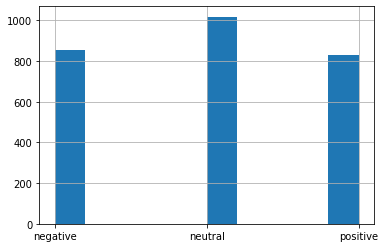

In [6]:
solution = Solution('./data', tokenizer='basic', model='gradient')

In [7]:
solution.train_test_split()

Train dataset split to train 2162, and 541 entries


## Custom Extractors

In [8]:
Solution.TweetFeatureExtractor().transform(solution.X_train)

n_chars  n_words  n_numeric  avg_word_len  xD  :D  )  (   !  !!  !!!  \
1149       42        6          0      6.000000   0   0  0  0   0   0    0   
824        33        4          0      6.600000   0   0  0  0   0   0    0   
165        92       22          1      4.000000   0   0  0  0   0   0    0   
999        32        6          0      4.571429   0   0  0  0   0   0    0   
1567       57        9          0      5.700000   0   0  0  0   0   0    0   
514       119       27          0      4.250000   0   0  0  0   0   0    0   
2359       22        3          0      5.500000   0   0  0  0   0   0    0   
2387       81       18          0      4.263158   0   1  0  0   1   0    0   
1898      111       25          0      4.269231   0   0  0  0   0   0    0   
662        23        4          0      4.600000   0   0  0  0   0   0    0   
2063       45        7          0      5.625000   0   0  0  0   0   0    0   
679        37        9          0      3.700000   0   0  0  0   0   0    0   
2105       23        4          0      4.600000   0   0  0  0   0   0    0   
872        32        7          0      4.000000   0   0  0  0   0   0    0   
939        33        6          0      4.714286   0   0  0  0   0   0    0   
1409       42        8          0      4.666667   0   0  0  0   0   0    0   
2140       58       13          0      4.142857   0   0  0  0   0   0    0   
940        39        7          0      4.875000   0   0  0  0   0   0    0   
2426       15        4          0      3.000000   0   1  0  0   0   0    0   
2511       72       14          0      4.800000   0   0  0  0   0   0    0   
841        34        6          0      4.857143   0   0  0  0   0   0    0   
882        23        3          1      5.750000   0   0  0  0   0   0    0   
366        39        9          0      3.900000   0   0  0  0   0   0    0   
2303       72       16          0      4.235294   0   0  0  0   0   0    0   
1960       27        6          0      3.857143   0   0  0  0   0   0    0   
1166       40        5          0      6.666667   0   0  0  0   0   0    0   
387        19        3          0      4.750000   0   0  0  0   0   0    0   
272        21        4          1      4.200000   0   0  0  0   0   0    0   
2135       75       13          0      5.357143   0   0  1  1   0   0    0   
1815       63       15          1      3.937500   0   0  0  0   0   0    0   
2121        9        1          0      4.500000   0   0  0  0   0   0    0   
844       111       27          2      3.964286   0   0  0  0   0   0    0   
618       104       25          0      4.000000   0   0  0  0   0   0    0   
297        39        8          1      4.333333   0   0  0  0   0   0    0   
1059       61       11          0      5.083333   0   0  0  0   0   0    0   
1847      107       17          0      5.944444   0   0  1  1   0   0    0   
1564       25        5          0      4.166667   0   0  0  0   0   0    0   
1936       42       12          0      3.230769   0   1  0  0   0   0    0   
1513       56        9          0      5.600000   0   0  0  0   0   0    0   
647        19        6          0      2.714286   0   0  0  0   0   0    0   
685        69       15          0      4.312500   0   0  0  0   0   0    0   
2286       48        7          0      6.000000   0   0  0  0   0   0    0   
76         85       18          0      4.473684   0   0  0  0   0   0    0   
1979       46       10          0      4.181818   0   0  0  0   0   0    0   
2120       40        8          0      4.444444   0   0  0  0   0   0    0   
1975       42        6          1      6.000000   0   0  1  1   0   0    0   
2240       74       14          0      4.933333   0   0  1  1   2   0    0   
2366       80       15          0      5.000000   0   0  0  0   1   0    0   
1569       36        6          0      5.142857   0   0  0  0   0   0    0   
1797       80       14          0      5.333333   0   0  0  0   0   0    0   
2661       63       12      

In [9]:
Solution.NERFeatureExtractor().transform(solution.X_train)

ORG  NORP  CARDINAL  PERSON  GPE  PRODUCT  WORK_OF_ART  PERCENT  DATE  \
0       0     0         0       0    0        0            0        0     0   
1       0     1         0       0    0        0            0        0     0   
2       1     0         0       0    0        0            0        0     0   
3       1     0         0       1    0        0            0        0     0   
4       2     0         0       1    0        0            0        0     1   
5       0     0         0       0    0        0            0        0     0   
6       0     0         0       0    1        0            0        0     0   
7       0     0         0       0    0        0            0        0     0   
8       0     0         0       0    0        0            0        0     1   
9       0     0         0       0    0        0            0        0     0   
10      0     0         0       0    0        0            0        0     0   
11      0     0         0       0    0        0            0        0     0   
12      0     0         0       0    0        0            0        0     0   
13      0     0         0       0    1        0            0        0     0   
14      1     0         0       0    0        0            0        0     0   
15      0     0         0       0    0        0            0        0     0   
16      0     0         0       0    0        0            0        0     1   
17      0     0         0       1    0        0            0        0     0   
18      0     0         0       0    0        0            0        0     0   
19      0     0         0       0    0        0            0        0     0   
20      0     0         0       0    0        0            0        0     0   
21      0     0         1       0    0        0            0        0     0   
22      0     0         0       0    0        0            0        0     0   
23      0     0         0       0    0        0            0        0     0   
24      0     0         0       0    0        0            0        0     0   
25      0     1         0       0    0        0            0        0     0   
26      0     0         0       0    0        0            0        0     0   
27      1     0         0       0    0        0            0        0     0   
28      0     0         0       0    0        0            0        0     0   
29      0     0         1       1    0        0            0        0     0   
30      0     0         0       0    0        0            0        0     0   
31      0     0         0       0    0        0            0        0     1   
32      0     0         0       0    0        0            0        0     0   
33      0     0         1       0    0        0            0        0     0   
34      0     0         0       1    1        0            0        0     0   
35      0     0         0       0    0        0            0        0     1   
36      0     0         0       0    1        0            0        0     0   
37      0     0         0       0    0        0            0        0     0   
38      0     0         0       1    1        0            0        0     0   
39      0     0         0       0    0        0            0        0     0   
40      0     0         0       0    0        0            0        0     0   
41      0     0         0       0    0        0            0        0     0   
42      0     0         0       0    0        0            0        0     0   
43      0     0         0       0    0        0            0        0     0   
44      0     0         0       0    0        0            0        0     1   
45      0     0         0       0    2        1            0        0     0   
46      1     0         0       0    0        0            0        0     0   
47      0     0         0       0    0        0            0        0     1   
48      0     1         0       0    0        0            0        0     0   
49      2     0         0       1    0        0         

# 2 Similar

In [10]:
%%capture --no-display
solution.find_similar('word_exist')

In [11]:
solution.find_similar('word_count')

In [12]:
solution.find_similar('TFIDF')

# 3 Machine Learning

In [13]:
solution.test_all()

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 3.762842 s
word_count/just_tokenization ready in 3.978016 s
TFIDF/just_tokenization ready in 6.021539 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 4.620613 s
word_count/stemming ready in 4.555298 s
TFIDF/stemming ready in 6.751131 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 6.214215 s
word_count/lemmatization ready in 3.951992 s
TFIDF/lemmatization ready in 6.567343 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 11.496593 s
word_count/stemming+ ready in 11.51685 s
TFIDF/stemming+ ready in 12.808721 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 606.739761 s
word_count/misspelling ready in 3.981813 s
TFIDF/misspelling ready in 6.148446 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 38.397958 s
word_count/lemmatization + misspelling ready in 4.270888 s
TFIDF/lemmatization + misspelling ready in 6.001737 s


In [14]:
solution.result().sort_values(by=['accuracy'], ascending=False)

name  accuracy        time
8                      TFIDF/lemmatization  0.942699    6.567343
5                           TFIDF/stemming   0.94085    6.751131
0             word_exist/just_tokenization  0.937153    3.762842
7                 word_count/lemmatization  0.937153    3.951992
13                  word_count/misspelling  0.937153    3.981813
12                  word_exist/misspelling  0.937153  606.739761
17       TFIDF/lemmatization + misspelling  0.937153    6.001737
3                      word_exist/stemming  0.937153    4.620613
2                  TFIDF/just_tokenization  0.937153    6.021539
1             word_count/just_tokenization  0.935305    3.978016
15  word_exist/lemmatization + misspelling  0.935305   38.397958
16  word_count/lemmatization + misspelling  0.935305    4.270888
6                 word_exist/lemmatization  0.933457    6.214215
4                      word_count/stemming  0.933457    4.555298
11                         TFIDF/stemming+  0.931608   12.808721
14                       TFIDF/misspelling  0.931608    6.148446
10                    word_count/stemming+  0.927911    11.51685
9                     word_exist/stemming+  0.927911   11.496593

In [15]:
example = ["School 21 is the best school. I am very happy that I entered and study in it.",
           "BREAKING: Indias December quarter GDP at 7 percent (Reuters forecast was 6.4 percent) ", 
           "Ministers of PMLN are happy like those students who never studied for exams  luckily exams got delayed.", 
           "Not surprised that I have the least amount of followers out of the whole cast sad  LOL"]
solution_predict = predict(solution, example)
solution_predict

transformation                                     word_exist/just_tokenization  \
source                                                                            
good day                                                                neutral   
BREAKING: Indias December quarter GDP at 7 perc...                      neutral   
Ministers of PMLN are happy like those students...                     positive   
Not surprised that I have the least amount of f...                     negative   

transformation                                     word_count/just_tokenization  \
source                                                                            
good day                                                                neutral   
BREAKING: Indias December quarter GDP at 7 perc...                      neutral   
Ministers of PMLN are happy like those students...                     positive   
Not surprised that I have the least amount of f...                     negative   

transformation                                     TFIDF/just_tokenization  \
source                                                                       
good day                                                           neutral   
BREAKING: Indias December quarter GDP at 7 perc...                 neutral   
Ministers of PMLN are happy like those students...                positive   
Not surprised that I have the least amount of f...                negative   

transformation                                     word_exist/stemming  \
source                                                                   
good day                                                       neutral   
BREAKING: Indias December quarter GDP at 7 perc...             neutral   
Ministers of PMLN are happy like those students...            positive   
Not surprised that I have the least amount of f...            negative   

transformation                                     word_count/stemming  \
source                                                                   
good day                                                       neutral   
BREAKING: Indias December quarter GDP at 7 perc...             neutral   
Ministers of PMLN are happy like those students...            positive   
Not surprised that I have the least amount of f...            negative   

transformation                                     TFIDF/stemming  \
source                                                              
good day                                                  neutral   
BREAKING: Indias December quarter GDP at 7 perc...        neutral   
Ministers of PMLN are happy like those students...       positive   
Not surprised that I have the least amount of f...       negative   

transformation                                     word_exist/lemmatization  \
source                                                                        
good day                                                            neutral   
BREAKING: Indias December quarter GDP at 7 perc...                  neutral   
Ministers of PMLN are happy like those students...                 positive   
Not surprised that I have the least amount of f...                 negative   

transformation                                     word_count/lemmatization  \
source                                                                        
good day                                                            neutral   
BREAKING: Indias December quarter GDP at 7 perc...                  neutral   
Ministers of PMLN are happy like those students...                 positive   
Not surprised that I have the least amount of f...                 negative   

transformation                                     TFIDF/lemmatization  \
source                                                                   
good day                                                       neutral   
BREAKING: Indias December quarter GDP at 7 perc...      

In [16]:
%%time
# logistic = Solution('./data', tokenizer='basic', model='logistic')
# logistic.train_test_split()
solution.model_name = 'logistic'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.63919 s
word_count/just_tokenization ready in 0.699118 s
TFIDF/just_tokenization ready in 0.750385 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 1.645809 s
word_count/stemming ready in 1.51328 s
TFIDF/stemming ready in 1.553191 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.877224 s
word_count/lemmatization ready in 0.961561 s
TFIDF/lemmatization ready in 0.869357 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 8.597357 s
word_count/stemming+ ready in 8.824946 s
TFIDF/stemming+ ready in 8.571597 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.694751 s
word_count/misspelling ready in 0.671585 s
TFIDF/misspelling ready in 0.688295 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.836326 s
word_count/lemmatization + misspelling ready in 0.862494 s
TFIDF/lemmatization + misspelling ready in 0.829715 s


name  accuracy      time
4                      word_count/stemming  0.942699   1.51328
0             word_exist/just_tokenization   0.94085   0.63919
15  word_exist/lemmatization + misspelling   0.94085  0.836326
12                  word_exist/misspelling  0.939002  0.694751
16  word_count/lemmatization + misspelling  0.939002  0.862494
3                      word_exist/stemming  0.939002  1.645809
5                           TFIDF/stemming  0.939002  1.553191
6                 word_exist/lemmatization  0.939002  0.877224
13                  word_count/misspelling  0.939002  0.671585
14                       TFIDF/misspelling  0.937153  0.688295
17       TFIDF/lemmatization + misspelling  0.937153  0.829715
1             word_count/just_tokenization  0.937153  0.699118
8                      TFIDF/lemmatization  0.937153  0.869357
7                 word_count/lemmatization  0.935305  0.961561
11                         TFIDF/stemming+  0.931608  8.571597
2                  TFIDF/just_tokenization  0.931608  0.750385
9                     word_exist/stemming+  0.931608  8.597357
10                    word_count/stemming+   0.92976  8.824946

CPU times: total: 39.3 s
Wall time: 40.6 s


In [17]:
%%time
# gradient = Solution('./data', tokenizer='basic', model='gradient')
# gradient.train_test_split()
solution.model_name = 'gradient'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 4.087843 s
word_count/just_tokenization ready in 3.832137 s
TFIDF/just_tokenization ready in 6.069004 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 4.683784 s
word_count/stemming ready in 4.417598 s
TFIDF/stemming ready in 6.265694 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 3.82879 s
word_count/lemmatization ready in 4.150891 s
TFIDF/lemmatization ready in 6.003142 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 11.31862 s
word_count/stemming+ ready in 11.044489 s
TFIDF/stemming+ ready in 12.371686 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 3.7327 s
word_count/misspelling ready in 3.845201 s
TFIDF/misspelling ready in 6.022181 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 3.939207 s
word_count/lemmatization + misspelling ready in 4.063136 s
TFIDF/lemmatization + misspelling ready in 6.230434 s


name  accuracy       time
17       TFIDF/lemmatization + misspelling   0.94085   6.230434
8                      TFIDF/lemmatization   0.94085   6.003142
2                  TFIDF/just_tokenization  0.939002   6.069004
5                           TFIDF/stemming  0.939002   6.265694
13                  word_count/misspelling  0.937153   3.845201
12                  word_exist/misspelling  0.937153     3.7327
1             word_count/just_tokenization  0.937153   3.832137
0             word_exist/just_tokenization  0.937153   4.087843
7                 word_count/lemmatization  0.935305   4.150891
6                 word_exist/lemmatization  0.935305    3.82879
4                      word_count/stemming  0.935305   4.417598
14                       TFIDF/misspelling  0.935305   6.022181
16  word_count/lemmatization + misspelling  0.935305   4.063136
3                      word_exist/stemming  0.933457   4.683784
15  word_exist/lemmatization + misspelling  0.933457   3.939207
11                         TFIDF/stemming+  0.931608  12.371686
9                     word_exist/stemming+  0.927911   11.31862
10                    word_count/stemming+  0.924214  11.044489

CPU times: total: 1min 43s
Wall time: 1min 47s


In [18]:
%%time
# forest = Solution('./data', tokenizer='basic', model='forest')
# forest.train_test_split()
solution.model_name = 'forest'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.757397 s
word_count/just_tokenization ready in 0.801726 s
TFIDF/just_tokenization ready in 0.830689 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 1.644473 s
word_count/stemming ready in 1.65399 s
TFIDF/stemming ready in 1.743288 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 1.016477 s
word_count/lemmatization ready in 1.141915 s
TFIDF/lemmatization ready in 0.968617 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 9.029434 s
word_count/stemming+ ready in 8.869748 s
TFIDF/stemming+ ready in 9.22855 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.819114 s
word_count/misspelling ready in 0.855537 s
TFIDF/misspelling ready in 0.834745 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.989082 s
word_count/lemmatization + misspelling ready in 1.10544 s
TFIDF/lemmatization + misspelling ready in 1.054556 s


name  accuracy      time
1             word_count/just_tokenization  0.942699  0.801726
15  word_exist/lemmatization + misspelling   0.94085  0.989082
13                  word_count/misspelling   0.94085  0.855537
3                      word_exist/stemming  0.939002  1.644473
16  word_count/lemmatization + misspelling  0.939002   1.10544
2                  TFIDF/just_tokenization  0.937153  0.830689
5                           TFIDF/stemming  0.937153  1.743288
12                  word_exist/misspelling  0.935305  0.819114
6                 word_exist/lemmatization  0.933457  1.016477
14                       TFIDF/misspelling  0.933457  0.834745
7                 word_count/lemmatization  0.931608  1.141915
0             word_exist/just_tokenization   0.92976  0.757397
9                     word_exist/stemming+  0.927911  9.029434
4                      word_count/stemming  0.927911   1.65399
10                    word_count/stemming+  0.926063  8.869748
17       TFIDF/lemmatization + misspelling  0.926063  1.054556
8                      TFIDF/lemmatization  0.918669  0.968617
11                         TFIDF/stemming+  0.913124   9.22855

CPU times: total: 48.9 s
Wall time: 44 s


In [19]:
%%time
# logistic = Solution('./data', tokenizer='tweet', model='logistic')
# logistic.train_test_split()
solution._tokenizer_name = 'tweet'
solution.model_name = 'logistic'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.637451 s
word_count/just_tokenization ready in 0.519834 s
TFIDF/just_tokenization ready in 0.557086 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 1.417949 s
word_count/stemming ready in 1.230372 s
TFIDF/stemming ready in 1.298703 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.622087 s
word_count/lemmatization ready in 0.719763 s
TFIDF/lemmatization ready in 0.635899 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 8.255306 s
word_count/stemming+ ready in 7.962166 s
TFIDF/stemming+ ready in 8.162836 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 24.423334 s
word_count/misspelling ready in 0.729483 s
TFIDF/misspelling ready in 0.518811 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.852768 s
word_count/lemmatization + misspelling ready in 0.708738 s
TFIDF/lemmatization + misspelling ready in 0.766209 s


name  accuracy       time
0             word_exist/just_tokenization   0.94085   0.637451
4                      word_count/stemming   0.94085   1.230372
9                     word_exist/stemming+   0.94085   8.255306
3                      word_exist/stemming  0.939002   1.417949
2                  TFIDF/just_tokenization  0.939002   0.557086
6                 word_exist/lemmatization  0.939002   0.622087
8                      TFIDF/lemmatization  0.939002   0.635899
1             word_count/just_tokenization  0.939002   0.519834
10                    word_count/stemming+  0.939002   7.962166
14                       TFIDF/misspelling  0.939002   0.518811
17       TFIDF/lemmatization + misspelling  0.939002   0.766209
5                           TFIDF/stemming  0.937153   1.298703
7                 word_count/lemmatization  0.937153   0.719763
12                  word_exist/misspelling  0.937153  24.423334
13                  word_count/misspelling  0.937153   0.729483
11                         TFIDF/stemming+  0.935305   8.162836
16  word_count/lemmatization + misspelling  0.935305   0.708738
15  word_exist/lemmatization + misspelling  0.933457   0.852768

CPU times: total: 58.6 s
Wall time: 1min


In [20]:
%%time
# gradient = Solution('./data', tokenizer='tweet', model='gradient')
# gradient.train_test_split()
solution.model_name = 'gradient'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 3.99713 s
word_count/just_tokenization ready in 4.085848 s
TFIDF/just_tokenization ready in 5.706112 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 4.682573 s
word_count/stemming ready in 4.355978 s
TFIDF/stemming ready in 6.453356 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 3.398804 s
word_count/lemmatization ready in 3.430513 s
TFIDF/lemmatization ready in 5.93725 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 10.569619 s
word_count/stemming+ ready in 10.799846 s
TFIDF/stemming+ ready in 12.137563 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 3.451116 s
word_count/misspelling ready in 3.681328 s
TFIDF/misspelling ready in 5.860546 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 3.781956 s
word_count/lemmatization + misspelling ready in 3.898858 s
TFIDF/lemmatization + misspelling ready in 5.695165 s


name  accuracy       time
9                     word_exist/stemming+  0.939002  10.569619
2                  TFIDF/just_tokenization  0.937153   5.706112
3                      word_exist/stemming  0.937153   4.682573
15  word_exist/lemmatization + misspelling  0.937153   3.781956
6                 word_exist/lemmatization  0.937153   3.398804
10                    word_count/stemming+  0.937153  10.799846
1             word_count/just_tokenization  0.935305   4.085848
16  word_count/lemmatization + misspelling  0.935305   3.898858
13                  word_count/misspelling  0.935305   3.681328
0             word_exist/just_tokenization  0.935305    3.99713
7                 word_count/lemmatization  0.935305   3.430513
8                      TFIDF/lemmatization  0.933457    5.93725
12                  word_exist/misspelling  0.933457   3.451116
14                       TFIDF/misspelling  0.933457   5.860546
5                           TFIDF/stemming  0.933457   6.453356
17       TFIDF/lemmatization + misspelling  0.931608   5.695165
4                      word_count/stemming   0.92976   4.355978
11                         TFIDF/stemming+  0.927911  12.137563

CPU times: total: 1min 39s
Wall time: 1min 43s


In [21]:
%%time
# forest = Solution('./data', tokenizer='tweet', model='forest')
# forest.train_test_split()
solution.model_name = 'forest'
solution.test_all()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.593464 s
word_count/just_tokenization ready in 0.642788 s
TFIDF/just_tokenization ready in 0.63314 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 1.469576 s
word_count/stemming ready in 1.475485 s
TFIDF/stemming ready in 1.548632 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.764891 s
word_count/lemmatization ready in 0.854418 s
TFIDF/lemmatization ready in 0.792032 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 7.738452 s
word_count/stemming+ ready in 8.275979 s
TFIDF/stemming+ ready in 8.621944 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.618829 s
word_count/misspelling ready in 0.633795 s
TFIDF/misspelling ready in 0.643019 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.821775 s
word_count/lemmatization + misspelling ready in 0.841005 s
TFIDF/lemmatization + misspelling ready in 0.961849 s


name  accuracy      time
15  word_exist/lemmatization + misspelling  0.942699  0.821775
13                  word_count/misspelling   0.94085  0.633795
14                       TFIDF/misspelling  0.937153  0.643019
0             word_exist/just_tokenization  0.935305  0.593464
17       TFIDF/lemmatization + misspelling  0.935305  0.961849
3                      word_exist/stemming  0.935305  1.469576
6                 word_exist/lemmatization  0.933457  0.764891
7                 word_count/lemmatization  0.933457  0.854418
8                      TFIDF/lemmatization  0.933457  0.792032
16  word_count/lemmatization + misspelling  0.933457  0.841005
10                    word_count/stemming+  0.931608  8.275979
11                         TFIDF/stemming+  0.931608  8.621944
12                  word_exist/misspelling  0.931608  0.618829
4                      word_count/stemming  0.931608  1.475485
1             word_count/just_tokenization   0.92976  0.642788
5                           TFIDF/stemming  0.927911  1.548632
9                     word_exist/stemming+  0.927911  7.738452
2                  TFIDF/just_tokenization  0.922366   0.63314

CPU times: total: 43.6 s
Wall time: 38.6 s


# 4 Bonus

In [22]:
%%time
solution.model_name = 'logistic'
solution._tokenizer_name = 'tweet'
solution.bonus()
display(solution.result().sort_values(by=['accuracy'], ascending=False))

  0%|          | 0/6 [00:00<?, ?it/s]

just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization ready in 0.473655 s
word_count/just_tokenization ready in 0.481165 s
TFIDF/just_tokenization ready in 0.68151 s


just_tokenization:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization/Tweet ready in 6.445057 s
word_count/just_tokenization/Tweet ready in 6.45308 s
TFIDF/just_tokenization/Tweet ready in 10.465091 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization/NER_Tweet ready in 34.371448 s
word_count/just_tokenization/NER_Tweet ready in 33.616434 s
TFIDF/just_tokenization/NER_Tweet ready in 36.212124 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/just_tokenization/NER ready in 27.274946 s
word_count/just_tokenization/NER ready in 26.732238 s
TFIDF/just_tokenization/NER ready in 26.986056 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming ready in 1.244089 s
word_count/stemming ready in 1.224319 s
TFIDF/stemming ready in 1.300918 s


stemming:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming/Tweet ready in 6.61595 s
word_count/stemming/Tweet ready in 5.927504 s
TFIDF/stemming/Tweet ready in 8.924965 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming/NER_Tweet ready in 32.162986 s
word_count/stemming/NER_Tweet ready in 31.349743 s
TFIDF/stemming/NER_Tweet ready in 36.07492 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming/NER ready in 25.631157 s
word_count/stemming/NER ready in 27.280829 s
TFIDF/stemming/NER ready in 26.623256 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization ready in 0.692912 s
word_count/lemmatization ready in 0.62733 s
TFIDF/lemmatization ready in 0.741454 s


lemmatization:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization/Tweet ready in 5.896804 s
word_count/lemmatization/Tweet ready in 6.479309 s
TFIDF/lemmatization/Tweet ready in 10.063711 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization/NER_Tweet ready in 32.889643 s
word_count/lemmatization/NER_Tweet ready in 32.228715 s
TFIDF/lemmatization/NER_Tweet ready in 35.840895 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization/NER ready in 28.219265 s
word_count/lemmatization/NER ready in 26.14864 s
TFIDF/lemmatization/NER ready in 26.229858 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+ ready in 7.957125 s
word_count/stemming+ ready in 8.092138 s
TFIDF/stemming+ ready in 8.317786 s


stemming+:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+/Tweet ready in 12.826369 s
word_count/stemming+/Tweet ready in 13.179115 s
TFIDF/stemming+/Tweet ready in 17.048735 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+/NER_Tweet ready in 38.920684 s
word_count/stemming+/NER_Tweet ready in 39.231244 s
TFIDF/stemming+/NER_Tweet ready in 44.240223 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/stemming+/NER ready in 37.649436 s
word_count/stemming+/NER ready in 33.952532 s
TFIDF/stemming+/NER ready in 32.946036 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling ready in 0.478265 s
word_count/misspelling ready in 0.621735 s
TFIDF/misspelling ready in 0.507539 s


misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling/Tweet ready in 5.669551 s
word_count/misspelling/Tweet ready in 5.129556 s
TFIDF/misspelling/Tweet ready in 10.064121 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling/NER_Tweet ready in 31.845703 s
word_count/misspelling/NER_Tweet ready in 31.762122 s
TFIDF/misspelling/NER_Tweet ready in 35.642028 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/misspelling/NER ready in 26.290008 s
word_count/misspelling/NER ready in 17.238037 s
TFIDF/misspelling/NER ready in 17.048775 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling ready in 0.537305 s
word_count/lemmatization + misspelling ready in 0.59588 s
TFIDF/lemmatization + misspelling ready in 0.526459 s


lemmatization + misspelling:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling/Tweet ready in 5.627026 s
word_count/lemmatization + misspelling/Tweet ready in 5.233389 s
TFIDF/lemmatization + misspelling/Tweet ready in 7.513139 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling/NER_Tweet ready in 21.643736 s
word_count/lemmatization + misspelling/NER_Tweet ready in 20.916025 s
TFIDF/lemmatization + misspelling/NER_Tweet ready in 27.006497 s


  0%|          | 0/3 [00:00<?, ?it/s]

word_exist/lemmatization + misspelling/NER ready in 19.869984 s
word_count/lemmatization + misspelling/NER ready in 21.847412 s
TFIDF/lemmatization + misspelling/NER ready in 21.573929 s


name  accuracy       time
6             word_exist/just_tokenization/NER_Tweet  0.946396  34.371448
8                  TFIDF/just_tokenization/NER_Tweet  0.946396  36.212124
20                          TFIDF/stemming/NER_Tweet  0.946396   36.07492
19                     word_count/stemming/NER_Tweet  0.944547  31.349743
51                      word_exist/misspelling/Tweet  0.944547   5.669551
18                     word_exist/stemming/NER_Tweet  0.944547  32.162986
30                word_exist/lemmatization/NER_Tweet  0.944547  32.889643
56                       TFIDF/misspelling/NER_Tweet  0.944547  35.642028
54                  word_exist/misspelling/NER_Tweet  0.944547  31.845703
43                    word_count/stemming+/NER_Tweet  0.942699  39.231244
16                         word_count/stemming/Tweet  0.942699   5.927504
15                         word_exist/stemming/Tweet  0.942699    6.61595
32                     TFIDF/lemmatization/NER_Tweet  0.942699  35.840895
65           TFIDF/lemmatization + misspelling/Tweet  0.942699   7.513139
66  word_exist/lemmatization + misspelling/NER_Tweet  0.942699  21.643736
3                 word_exist/just_tokenization/Tweet  0.942699   6.445057
68       TFIDF/lemmatization + misspelling/NER_Tweet  0.942699  27.006497
40                        word_count/stemming+/Tweet   0.94085  13.179115
42                    word_exist/stemming+/NER_Tweet   0.94085  38.920684
0                       word_exist/just_tokenization   0.94085   0.473655
46                          word_count/stemming+/NER   0.94085  33.952532
44                         TFIDF/stemming+/NER_Tweet   0.94085  44.240223
45                          word_exist/stemming+/NER   0.94085  37.649436
27                    word_exist/lemmatization/Tweet   0.94085   5.896804
55                  word_count/misspelling/NER_Tweet   0.94085  31.762122
63      word_exist/lemmatization + misspelling/Tweet   0.94085   5.627026
28                    word_count/lemmatization/Tweet   0.94085   6.479309
36                              word_exist/stemming+   0.94085   7.957125
13                               word_count/stemming   0.94085   1.224319
21                           word_exist/stemming/NER   0.94085  25.631157
26                               TFIDF/lemmatization  0.939002   0.741454
22                           word_count/stemming/NER  0.939002  27.280829
2                            TFIDF/just_tokenization  0.939002    0.68151
67  word_count/lemmatization + misspelling/NER_Tweet  0.939002  20.916025
4                 word_count/just_tokenization/Tweet  0.939002    6.45308
62                 TFIDF/lemmatization + misspelling  0.939002   0.526459
59                             TFIDF/misspelling/NER  0.939002  17.048775
9                   word_exist/just_tokenization/NER  0.939002  27.274946
11                       TFIDF/just_tokenization/NER  0.939002  26.986056
12                               word_exist/stemming  0.939002   1.244089
29                         TFIDF/lemmatization/Tweet  0.939002  10.063711
50                                 TFIDF/misspelling  0.939002   0.507539
71             TFIDF/lemmatization + misspelling/NER  0.939002  21.573929
39                        word_exist/stemming+/Tweet  0.939002  12.826369
24                          word_exist/lemmatization  0.939002   0.692912
34                      word_count/lemmatization/NER  0.939002   26.14864
37                              word_count/stemming+  0.939002   8.092138
23                                TFIDF/stemming/NER  0.939002  26.623256
35                           TFIDF/lemmatization/NER  0.939002  26.229858
1                       word_count/just_tokenization  0.939002   0.481165
10                  word_count/just_tokenization/NER  0.937153  26.732238
69        word_exist/lemmatization + misspelling/NER  0.937153  19.869984
25                          word_count/lemmatization  0.937153    0.62733
5                      TFIDF/just_tokenization/Tweet

CPU times: total: 20min
Wall time: 20min 52s


In [23]:
predict(solution, example)

transformation                                     word_exist/just_tokenization  \
source                                                                            
good day                                                                neutral   
BREAKING: Indias December quarter GDP at 7 perc...                      neutral   
Ministers of PMLN are happy like those students...                     positive   
Not surprised that I have the least amount of f...                     negative   

transformation                                     word_count/just_tokenization  \
source                                                                            
good day                                                                neutral   
BREAKING: Indias December quarter GDP at 7 perc...                      neutral   
Ministers of PMLN are happy like those students...                     positive   
Not surprised that I have the least amount of f...                     negative   

transformation                                     TFIDF/just_tokenization  \
source                                                                       
good day                                                          positive   
BREAKING: Indias December quarter GDP at 7 perc...                 neutral   
Ministers of PMLN are happy like those students...                positive   
Not surprised that I have the least amount of f...                negative   

transformation                                     word_exist/just_tokenization/Tweet  \
source                                                                                  
good day                                                                      neutral   
BREAKING: Indias December quarter GDP at 7 perc...                            neutral   
Ministers of PMLN are happy like those students...                           positive   
Not surprised that I have the least amount of f...                           negative   

transformation                                     word_count/just_tokenization/Tweet  \
source                                                                                  
good day                                                                      neutral   
BREAKING: Indias December quarter GDP at 7 perc...                            neutral   
Ministers of PMLN are happy like those students...                           positive   
Not surprised that I have the least amount of f...                           negative   

transformation                                     TFIDF/just_tokenization/Tweet  \
source                                                                             
good day                                                                 neutral   
BREAKING: Indias December quarter GDP at 7 perc...                       neutral   
Ministers of PMLN are happy like those students...                      positive   
Not surprised that I have the least amount of f...                      negative   

transformation                                     word_exist/just_tokenization/NER_Tweet  \
source                                                                                      
good day                                                                          neutral   
BREAKING: Indias December quarter GDP at 7 perc...                                neutral   
Ministers of PMLN are happy like those students...                               positive   
Not surprised that I have the least amount of f...                               negative   

transformation                                     word_count/just_tokenization/NER_Tweet  \
source                                                                                      
good day                                                                          neutral   
BREAKING: Indias December quarter GDP at 7 perc...                                neutral   
Ministers of PMLN are happy